Need to simplify the loading and setting up of a new tracklog

We should immediately load the GPS to get the proper timings so 
everything correlates between IGC and datalogged, and then be able to 
plot sets of IGCs at a time.

We should load Q records with the correct datetime, and offset the others 
by Rdatetime0

We need the R record because it has the date in it!


Things to do:
* Plot terrain underlay
* Interactive plot 2 flights at a time (list of fds)
* Clarify Hough transform calculations as a means to generate a vx vy for the wind
* Calculate wind direction within short section using Hough
* Plot whiskers for bank angles

Done:
* allow use of IGC data
* Plot vario
* Calculate barometric conversion from GPS
* Plot colour by velocity
* Plot whiskers for orientation
* Subtract wind direction from position (or velocity)



In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib


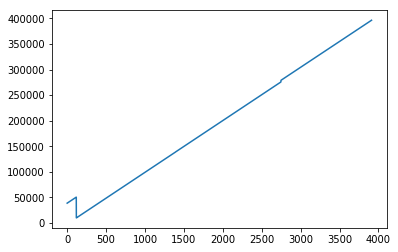

In [10]:
import re
ts = [int(l[2:], 16)  for l in re.findall("Ut\w{8}", open(fname).read()) ]
plt.plot(ts)

In [2]:
import re

fname = "/home/julian/Downloads/hdata-2019-03-29_17-34-50.log"
fnamea = fname+"a"
fout = open(fnamea, "w")
prevthex = None
for l in open(fname):
    mu = re.match("Ut(\w{8})i(\w\w)", l)
    mua = re.match("a\wt(\w{8})", l)
    if mu:
        if prevthex:
            fout.write("aUt%si%s\n" % (prevthex, mu.group(2)))
    else:
        fout.write(l)
        if mua:
            prevthex = mua.group(1)
fout.close()

fd = loaders.FlyDat(fnamea)

Setting knowndate 2019-03-29
should be same 2019-03-29 00:00:00 2019-03-29 00:00:00
badline End(3917,5212)

aF:2275, aQ:324, aV:325, aZ:2273, aU:3904
Made for Q 0 last index 0
Made for V 0 last index 0
No absolute time found 2000-01-01 00:00:00


In [3]:
fd.aRdatetime0

Timestamp('2019-03-29 16:45:41.878000')

In [3]:
fd.LoadC("aQ")
fd.LoadC("aU")

Made for aQ 324 last index 324
pCattrname aQ
Setting aRdatetime0 2019-03-29 16:45:41.931762345 from 2019-03-29 16:45:41.878000 with std 10.09
Made for aU 3904 last index 3904
pCattrname aU


In [ ]:
daU.pop()

In [22]:
daU = fd.aU.diff()
daU = daU[(daU.b == 1) | (daU.b == -1)]
if daU.b.iloc[0] == -1:
    del daU.iloc[0]
coasttimes = [ ]
for i in range(1, len(daU), 2):
    coasttimes.append((daU.iloc[i-1].name, daU.iloc[i].name))
coasttimes
daU

AttributeError: __delitem__

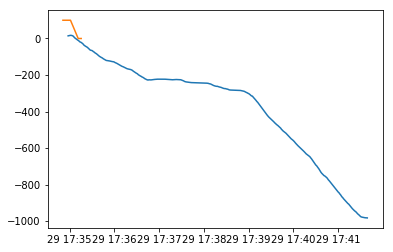

In [13]:
fd.LoadC("aQ")
plt.plot(fd.aU.b.iloc[:150]*100)


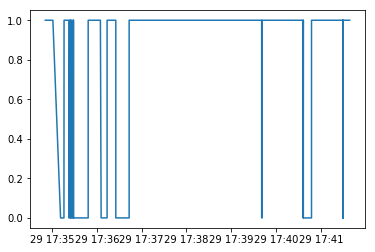

In [6]:
plt.plot(fd.aU.b)


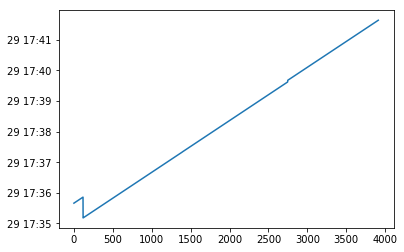

In [17]:
plt.plot(list(fd.pU.Dust.index.to_series()))

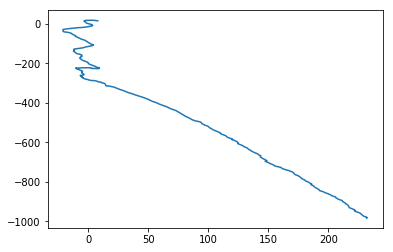

In [9]:
plt.plot(fd.aQ.x, fd.aQ.y)


In [2]:
from hacktrack import loaders
dname = "/home/julian/data/hanglog/2019-03-25-llangollen/"
christopos = dname+"20190325170820christo/hdata-2019-03-25_17-08-20B.pos"
christoigc1 = dname+"christoigc/05-1817.IGC"
christoigc2 = dname+"christoigc/20190325-171238-Christo.1.igc"
christoigc3 = dname+"christoigc/2019-03-25-XCS-AAA-04.igc"
fd = loaders.FlyDat(christopos)
fd.LoadIGC(christoigc1);
fd.LoadIGC(christoigc2);
fd.LoadIGC(christoigc3);

#(fd.pIGC.alt+240).plot()
#fd.pPOS.alt.plot()


Setting knowndate 2019-03-25


In [3]:
from hacktrack import clickables
clickables.plotinteractivegpstrack(fd)


Output(layout=Layout(height='400px'))

In [42]:
import ipywidgets as widgets
coloptions = widgets.Dropdown(options=['Tseries', 'TZ', 'XY', 'altitude', 'velocity', 'vario', 'YZ'])
help(widgets.Dropdown)

Help on class Dropdown in module ipywidgets.widgets.widget_selection:

class Dropdown(_Selection)
 |  Allows you to select a single item from a dropdown.
 |  
 |  Parameters
 |  ----------
 |  options: list
 |      The options for the dropdown. This can either be a list of values, e.g.
 |      ``['Galileo', 'Brahe', 'Hubble']`` or ``[0, 1, 2]``, or a list of
 |      (label, value) pairs, e.g.
 |      ``[('Galileo', 0), ('Brahe', 1), ('Hubble', 2)]``.
 |  
 |  index: int
 |      The index of the current selection.
 |  
 |  value: any
 |      The value of the current selection. When programmatically setting the
 |      value, a reverse lookup is performed among the options to check that
 |      the value is valid. The reverse lookup uses the equality operator by
 |      default, but another predicate may be provided via the ``equals``
 |      keyword argument. For example, when dealing with numpy arrays, one may
 |      set ``equals=np.array_equal``.
 |  
 |  label: str
 |      The label

In [44]:
dz.index

DatetimeIndex([       '2019-03-25 17:28:07', '2019-03-25 17:28:07.200000',
               '2019-03-25 17:28:07.400000', '2019-03-25 17:28:07.600000',
               '2019-03-25 17:28:07.800000',        '2019-03-25 17:28:08',
               '2019-03-25 17:28:08.200000', '2019-03-25 17:28:08.400000',
               '2019-03-25 17:28:08.600000', '2019-03-25 17:28:08.800000',
               ...
                      '2019-03-25 17:31:30', '2019-03-25 17:31:30.200000',
               '2019-03-25 17:31:30.400000', '2019-03-25 17:31:30.600000',
               '2019-03-25 17:31:30.800000',        '2019-03-25 17:31:31',
               '2019-03-25 17:31:31.200000', '2019-03-25 17:31:31.400000',
               '2019-03-25 17:31:31.600000', '2019-03-25 17:31:31.800000'],
              dtype='datetime64[ns]', length=1025, freq=None)

In [47]:
dz;

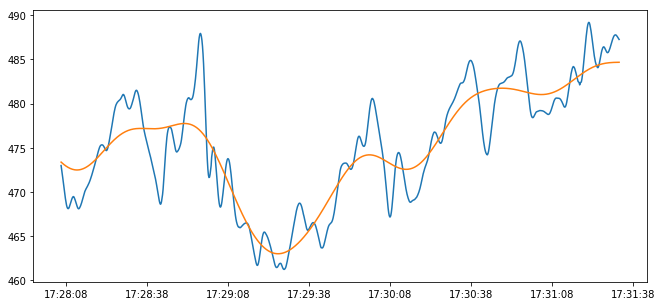

In [73]:
plt.figure(figsize=(11,5))
plt.plot(alt)
falt = utils.FiltFiltButter(alt, f=0.01)
plt.plot(falt)


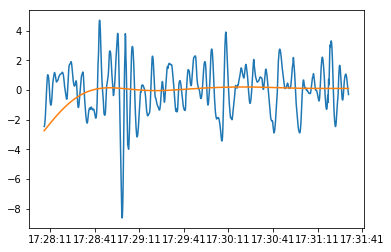

In [68]:
#pQ = fd.pIGCs[0][fd.t0:fd.t1]

#alt = pQ.alt
#dt = alt.index.to_series().diff()[1:].mean()/pandas.Timedelta(seconds=1)
#dz = (alt.shift(-1, fill_value=alt.iloc[0]) - alt.shift(fill_value=alt.iloc[0]))/(2*dt)
#dz = dz.iloc[5:-5]
plt.plot(dz)
fdz = utils.FiltFiltButter(dz)
plt.plot(fdz)
#pandas.Series(res, dz.index);


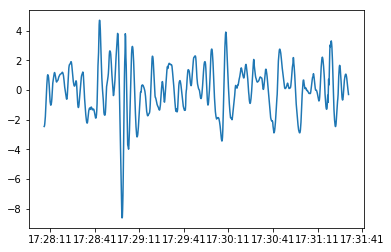

In [67]:
pQ = fd.pIGCs[0][fd.t0:fd.t1]

alt = pQ.alt
dt = alt.index.to_series().diff()[1:].mean()/pandas.Timedelta(seconds=1)
dz = (alt.shift(-1, fill_value=alt.iloc[0]) - alt.shift(fill_value=alt.iloc[0]))/(2*dt)
dz = dz.iloc[5:-5]
plt.plot(dz)
#utils.FiltFiltButter(dz)

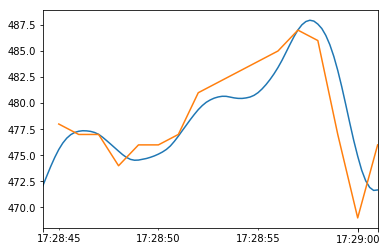

In [39]:
#len(fd.pIGCs)
pQ = fd.pIGCs[0][fd.t0:fd.t1]
#pQ.alt.diff().plot()
pQ.alt.plot()
pQ = fd.pIGCs[1][fd.t0:fd.t1]
(pQ.alt+235).plot()

In [9]:
pQ = fd.pQ[fd.t0:fd.t1]



j


In [ ]:
# "lat", "lng", "alt"
GPS_UTC_SECONDS_DIFFERENCE = -18
def loadpos(fname):
    w = pandas.read_csv(fname, skiprows=9, sep="\s+")
    w["time"] = pandas.to_datetime(w["GPST"]) + pandas.Timedelta(seconds=GPS_UTC_SECONDS_DIFFERENCE)
    w = w.set_index("time")
    
    earthrad = 6378137
    nyfac = 2*math.pi*earthrad/360
    if lng0 is None:
        lng0, lat0 = w[["longitude(deg)", "latitude(deg)"]].iloc[0]
    exfac = nyfac*math.cos(math.radians(lat0))
    w["x"] = (w["longitude(deg)"] - lng0)*exfac  
    w["y"] = (w["latitude(deg)"] - lat0)*nyfac
    w["z"] = w["height(m)"]

    return w

fposA = "/home/julian/data/hanglog/ormeaupark1/hdata-2019-03-04_09-23-38A.pos"
fposB = "/home/julian/data/hanglog/ormeaupark1/hdata-2019-03-04_09-23-38B.pos"

wA = loadpos(fposA)
wB = loadpos(fposB)

wA.columns


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fname = "data/022.TXT"
fname = "data/022-short.TXT"
fname = "data/029.TXT"
fname = "/home/julian/repositories/Future-Hangglider/hacktrack/data/8B1B0912.IGC"

fd = loaders.FlyDat(fname, knowndate="2018-08-05")


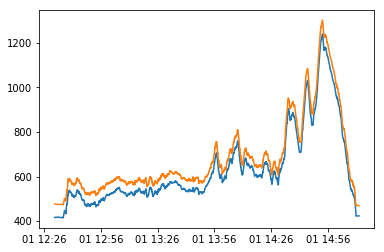

In [2]:
plt.plot(fd.pIGC.altb)
plt.plot(fd.pIGC.alt)

In [3]:
from hacktrack import clickables
clickables.plotinteractivegpstrack(fd)


Output(layout=Layout(height='400px'))

<Figure size 936x576 with 0 Axes>

In [8]:
fd.LoadC("F")
baro = fd.pF[fd.t0:fd.t1].Pr
utils.BaroToAltComplete(baro, fd.pQ.alt, gpsoffset=None, plt=None)
baro*-0.037867 + 3889.935160
(102726 - baro)*0.037867

3889.935160/-0.037867

GPS offset determined by BaroToAltLinear as [ 524.28775]
balt = baro*-0.037867 + 3889.935160


-102726.25663506484

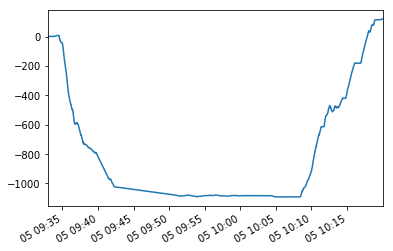

In [9]:
fd.pQ.x.plot()

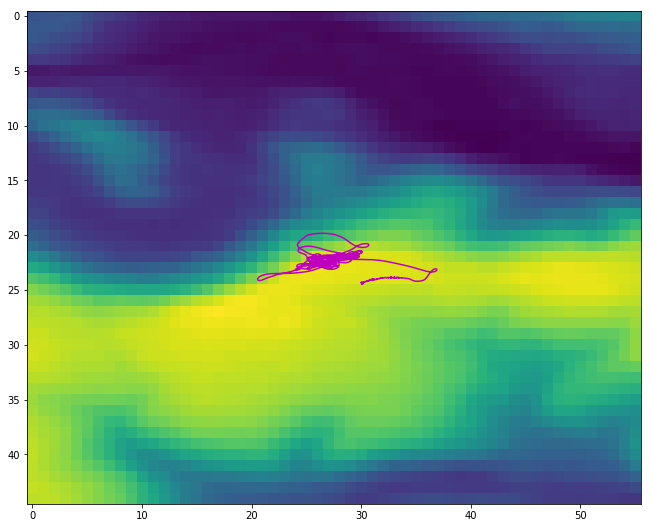

In [45]:
tp = utils.TerrainPlot(fd.pQ, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, fd.pQ, "m")


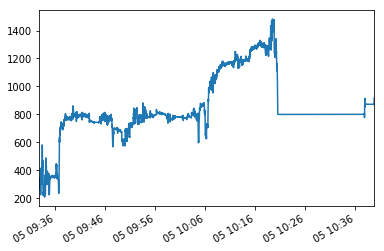

In [27]:
import numpy
#g = numpy.sqrt(fd.pZ.gx**2 + fd.pZ.gy**2 + fd.pZ.gz**2)
#plt.plot(g)
#a = numpy.sqrt(fd.pZ.ax**2 + fd.pZ.ay**2 + fd.pZ.az**2)
#plt.plot(a)
fd.pZ.heading.plot()

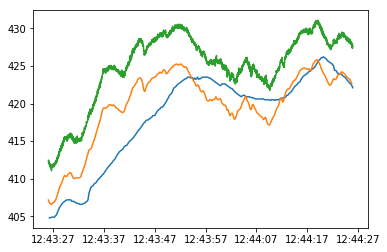

In [18]:
plt.plot(alt)
plt.plot(balt)
fbalt = baro*k.slope + k.intercept
plt.plot(fbalt+5)

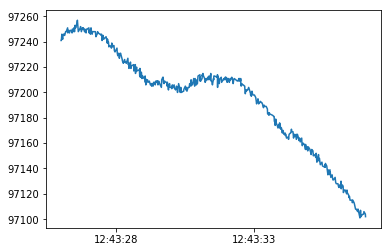

In [21]:
plt.plot(baro.iloc[:500])


In [8]:
fdI = loaders.FlyDat("data/longmynd15k.IGC")


6328

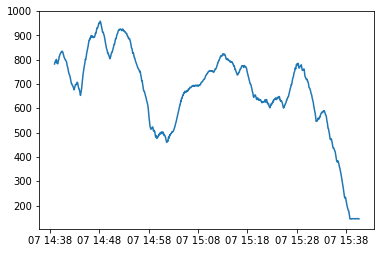

In [26]:
k = fdI.pIGC.iloc[4500:]
plt.plot(k.altb)

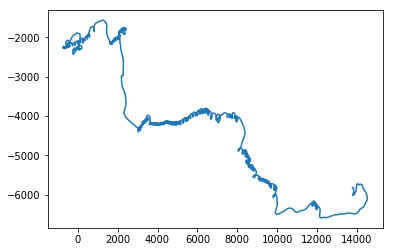

In [24]:
k = fdI.pIGC.iloc[4500:]
plt.plot(k.x, k.y)

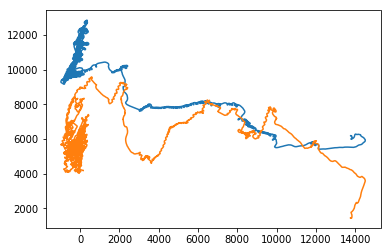

In [17]:
plt.plot(fdI.pIGC.x, fdI.pIGC.y+12000)
plt.plot(fdI.pIGC.x, fdI.pIGC.altb*10)

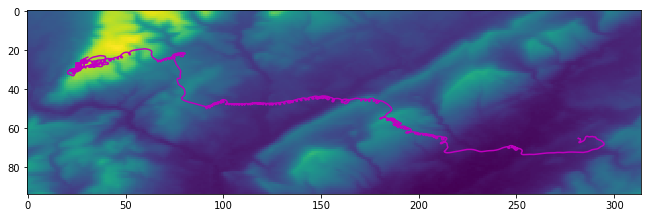

In [48]:
q = fdI.pIGC.iloc[-2200:]
tp = utils.TerrainPlot(q, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, q, "m")


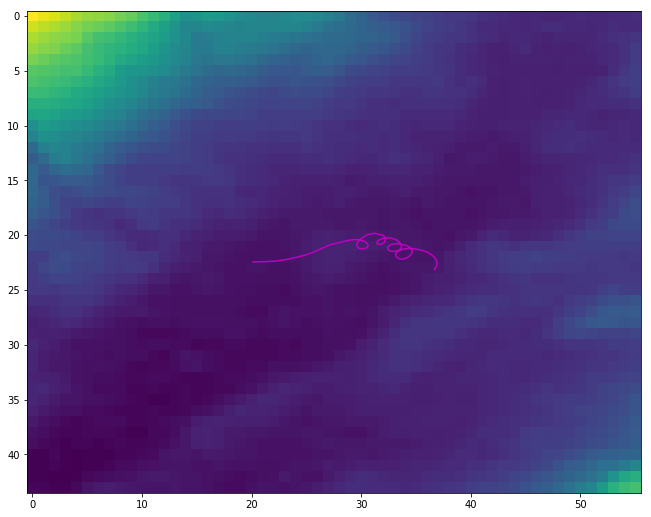

In [43]:
q = fdI.pIGC.iloc[-260:-190]
tp = utils.TerrainPlot(q, tiledirectory="/home/julian/hgstuff/hgtterrains")
tp.plotterrain(plt)
tp.plotgps(plt, q, "m")


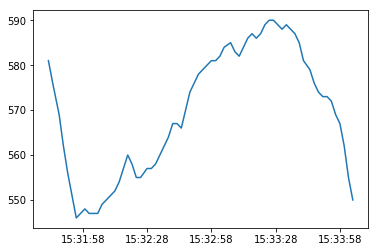

In [44]:
plt.plot(q.altb)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fdI = loaders.FlyDat("data/885B0912.IGC", fdother=fd)


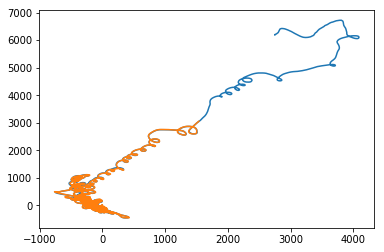

In [3]:
plt.plot(fdI.pIGC.x, fdI.pIGC.y)
plt.plot(fd.pQ.x, fd.pQ.y)

In [24]:
# Hough transform calculations (to get the velocity vectors, instead of by eye)
# define the grid array of velocities as between -10 and +10m/s
wsx = numpy.linspace(-5, 5, 21)
wsy = numpy.linspace(-5, 5, 21)
td = 2  # seconds between each sample
wxx, wyy = numpy.meshgrid(wsx, wsy)

# with too narrow a band (large houghspread) the single point sample in each cell is not 
# representative of the overall value that should be assigned to the cell
def F(p0x, p0y, p1x, p1y, p2x, p2y, houghspread, wxx, wyy):
    D = numpy.exp(-houghspread*(((p1x - p0x - wxx*td)**2 + (p1y - p0y - wyy*td)**2) - 
                                ((p2x - p1x - wxx*td)**2 + (p2y - p1y - wyy*td)**2))**2)
    return D / sum(sum(D))


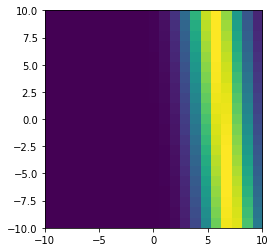

In [5]:
# example showing of the probability field
houghspread = 0.0002
Hextents = [wsx[0], wsx[-1], wsy[0], wsy[-1]]
D = F(0, 0, 10, 0, 26.4, 0.5, houghspread, wxx, wyy)
plt.imshow(D, origin='lower', extent=Hextents)

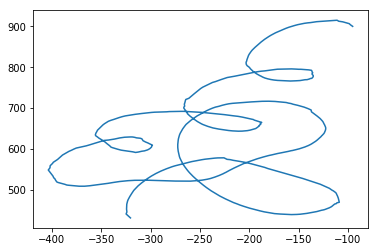

In [16]:
pQ = fd.pQ[fd.t0:fd.t1]
len(pQ)
plt.plot(pQ.x, pQ.y)

Peak value 0.0 -1.0


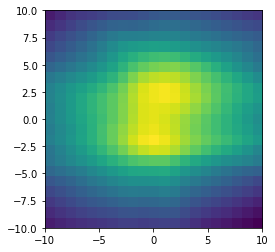

In [26]:
# sum these probability fields for sets of three points in the tracklog
def houghtrack(tlx, tly, houghspread):
    H = numpy.zeros((len(wsx), len(wsy)))
    for i in range(2, len(tlx)):
        H += F(tlx[i-2], tly[i-2], tlx[i-1], tly[i-1], tlx[i], tly[i], 
               houghspread, wxx, wyy)
    return H

tlx, tly = pQ.x, pQ.y
H = houghtrack(tlx, tly, houghspread*100)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
print("Peak value", wsx[ix], wsy[iy])


In [10]:
# to make the short version
t = open("data/022.TXT").read()
import re
print(len(t))
t1 = re.sub("N.*?\n", "", t)
print(len(t1))
k1 = t1.find("\n\n")
t1[:k1+2]
s1 = k1+10000018
s2 = k1+10360050
t2 = t1[s1:s2]
f = open("data/022-short.TXT", "w")
f.write(t1[:k1+2]+t1[s1:s2])
f.close()

26105569
24487596
